In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Getting the data and feature engineering

In [3]:
#Creating the functiong that will get the data for us
def get_data(league):
    
    files = [file for file in listdir(f'./../raw_data/{league}')]
    data = pd.DataFrame()

    for file in files:
        #print(file)
        df = pd.read_csv(f'./../raw_data/{league}/'+file)
        data = pd.concat([data, df])
    return data

In [4]:
#, error_bad_lines=False or , on_bad_lines='skip' eredivisie

In [29]:
data = get_data(league='greece')

In [30]:
data.shape

(3079, 143)

In [31]:
def feature_engineering(data, b=20):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
    '''
        
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5

    # payout of betting on over 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_over_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    # payout of betting on under 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_under_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #Implied Probability OVER 2.5 goals for overall market (AvgC)
    data['Implied Probability >2.5']=1/data['AvgC>2.5']*100
    
    #Implied Probability UNDER 2.5 goals for overall market (AvgC)
    data['Implied Probability <2.5']=1/data['AvgC<2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365C>2.5']*100
    
    # Binning the implied probabilities with bins of 10
    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()
    
    data['binned >2.5'] = pd.cut(data['Implied Probability >2.5'], bins)
    data['binned <2.5'] = pd.cut(data['Implied Probability <2.5'], bins)
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    
    return data

In [32]:
data = feature_engineering(data)

In [33]:
data.shape

(3012, 164)

In [34]:
data['HomeTeam'].isna().sum(), data['AwayTeam'].isna().sum()

(0, 0)

In [35]:
fdf = data[['Implied Probability >2.5','over_2.5_goals','binned >2.5','payout_over_2.5']]
fdf_under = data[['Implied Probability <2.5','under_2.5_goals','binned <2.5','payout_under_2.5']]
fdf_under_365 = data[['Implied Probability <2.5 365','under_2.5_goals','binned <2.5 365','payout_under_2.5_365']]
fdf_under_pinacle = data[['Implied Probability <2.5 pinacle','under_2.5_goals','binned <2.5 pinacle','payout_under_2.5_pinacle']]
fdf_over = data[['Implied Probability >2.5','over_2.5_goals','binned >2.5','payout_over_2.5']]
fdf_over_pinacle = data[['Implied Probability >2.5 pinacle','over_2.5_goals','binned >2.5 pinacle','payout_over_2.5_pinacle']]
fdf_over_365 = data[['Implied Probability >2.5 365','over_2.5_goals','binned >2.5 365','payout_over_2.5_365']]

In [36]:
fdf.groupby('binned >2.5')['payout_over_2.5'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned >2.5,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",25,0.000,0.723200,3.17
"(35, 40]",133,0.000,0.997068,2.84
"(40, 45]",219,0.000,0.851233,2.49


In [37]:
#group by BINS of implied probability (whole market) for < 2.5 goals --> series is the number of games
fdf_under.groupby('binned <2.5')['payout_under_2.5'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",5,2.990,1.892000,3.31
"(35, 40]",11,0.000,0.457273,2.53
"(40, 45]",24,0.000,0.969167,2.49


In [38]:
# Same only for 365 bookie
fdf_under_365.groupby('binned <2.5 365')['payout_under_2.5_365'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 365,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",3,3.40,2.300000,3.50
"(30, 35]",3,0.00,1.033333,3.10
"(35, 40]",10,0.00,0.510000,2.60
"(40, 45]",24,0.00,0.970833,2.40


In [39]:
fdf_under_pinacle.groupby('binned <2.5 pinacle')['payout_under_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",1,3.430,3.430000,3.43
"(30, 35]",6,0.000,1.076667,3.29
"(35, 40]",14,0.000,0.739286,2.68
"(40, 45]",27,0.000,0.874074,2.47


In [40]:
fdf_over_pinacle.groupby('binned >2.5 pinacle')['payout_over_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned >2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",1,0.000,0.000000,0.00
"(30, 35]",47,0.000,0.699574,3.17
"(35, 40]",165,0.000,1.093515,2.85
"(40, 45]",194,0.000,0.814639,2.49


In [41]:
fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle']

1      2.00
6      0.00
19     0.00
20     2.04
25     0.00
41     0.00
46     2.13
53     0.00
68     2.03
94     2.04
100    0.00
120    2.01
137    0.00
166    0.00
173    2.04
210    2.17
227    2.17
238    2.08
4      0.00
5      2.07
39     0.00
46     0.00
49     0.00
75     2.01
100    0.00
110    2.10
131    0.00
135    0.00
141    0.00
149    2.11
168    2.08
212    2.11
214    0.00
228    0.00
230    0.00
233    0.00
2      2.06
18     2.05
47     0.00
49     2.06
64     2.22
84     2.08
85     0.00
97     0.00
104    2.21
112    0.00
118    2.03
132    0.00
134    2.02
157    2.08
179    0.00
181    2.00
214    0.00
229    2.05
Name: payout_under_2.5_pinacle, dtype: float64

## CLT - Central Limit Theorem Analysis

<AxesSubplot:ylabel='Count'>

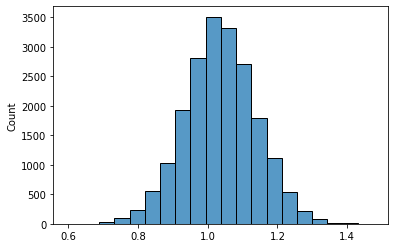

In [42]:
n = 100
N = 20000
means = [fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].sample(n, replace=True).mean() for i in range(N)]

sns.histplot(means, bins=20)

In [43]:
mu = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].mean()
sigma = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].std()

In [44]:
from scipy.stats import skew, kurtosis

# $CHALLENGIFY_BEGIN
index_df = ['mean', 'stdev', 'kurtosis', 'skewness']
theory = [mu, sigma/np.sqrt(n), 0, 0]
real_life = [np.mean(means), np.std(means), skew(means), kurtosis(means)]
comparison_df = pd.DataFrame(list(zip(theory,real_life)), 
                             columns = ["CLT Theory","Real Tips"],
                             index = index_df)
round(comparison_df,2)
# $CHALLENGIFY_END

,CLT Theory,Real Tips
mean,1.04,1.04
stdev,0.10,0.10
kurtosis,0.00,0.02
skewness,0.00,-0.01


## Analysing the numbers of a Buyuksehyr team

In [26]:
#general numbers of the team

In [27]:
buyu_df = data[(data['HomeTeam'] == 'Buyuksehyr') | (data['AwayTeam'] == 'Buyuksehyr')]
number_of_games = len(buyu_df)
total_goals = int(buyu_df[['nb_goals']].sum())
mean_goals_games = total_goals / number_of_games

ZeroDivisionError: division by zero

In [ ]:
number_of_games, total_goals, mean_goals_games

In [ ]:
buyu_df['under_2.5_goals'].value_counts()[1]

In [ ]:
#Home numbers of the team

In [ ]:
buyu_home_df = buyu_df[buyu_df['HomeTeam'] == 'Buyuksehyr']
goals_as_home = int(buyu_home_df['FTHG'].sum())
total_goals_ishome = int(buyu_home_df[['nb_goals']].sum())
total_away_goals = int(buyu_home_df['FTAG'].sum())
total_home_victory = buyu_home_df['FTR'].value_counts()[0]
total_home_draws = buyu_home_df['FTR'].value_counts()[1]
total_home_losses = buyu_home_df['FTR'].value_counts()[2]
mean_home_goals_games = total_goals_ishome / 192

In [ ]:
buyu_home_df['under_2.5_goals'].value_counts()

In [ ]:
goals_as_home, total_away_goals, total_goals_ishome, mean_home_goals_games, total_home_victory, total_home_draws, total_home_losses

In [ ]:
buyu_home_df['FTHG'].value_counts()

In [ ]:
#Away numbers of the team

In [ ]:
buyu_away_df = buyu_df[buyu_df['AwayTeam'] == 'Buyuksehyr']

In [ ]:
goals_as_away = int(buyu_away_df['FTAG'].sum())
total_goals_isaway = int(buyu_away_df[['nb_goals']].sum())
total_thome_goals = int(buyu_away_df['FTHG'].sum())
total_away_victory = buyu_away_df['FTR'].value_counts()[0]
total_away_draws = buyu_away_df['FTR'].value_counts()[2]
total_away_losses = buyu_away_df['FTR'].value_counts()[1]
mean_away_goals_games = total_goals_isaway / 192

In [ ]:
buyu_away_df['under_2.5_goals'].value_counts()

In [ ]:
buyu_odd_away = 1/(109/192)    
buyu_odd_away

In [ ]:
goals_as_away, total_thome_goals, total_goals_isaway, mean_away_goals_games, total_away_victory, total_away_draws, total_away_losses

In [ ]:
buyu_away_df[['nb_goals']].value_counts()

In [ ]:
buyu_away_df['FTR'].value_counts()

## Creating the home and away under odds feature

In [ ]:
'''lst1 = []
lst2 = []
for i, team in enumerate(data['HomeTeam']):
    total = len(data[data['HomeTeam'] == team])
    n_under_home = data[data['HomeTeam'] == team]['under_2.5_goals'].value_counts()[1]
    lst1.append(1/(n_under_home/total))
    lst2.append(n_under_home/total)
data['odds_home_under'] = lst1
data['prob_home_under'] = lst2'''

In [ ]:
'''lst3 = []
lst4  = []
for i, team in enumerate(data['AwayTeam']):
    total2 = len(data[data['AwayTeam'] == team])
    n_under_away2 = data[data['AwayTeam'] == team]['under_2.5_goals'].value_counts()[1]
    lst3.append(1/(n_under_away2 / total2))
    lst4.append(n_under_away2 / total2)
data['odds_away_under'] = lst3
data['prob_away_under'] = lst4'''

In [ ]:
data.head(23)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
date = data['Date'].iloc[21]
data[(data['HomeTeam'] == 'Goztep') & (data['Date'] < date)]
data[(data['HomeTeam'] == 'Goztep') & (data['Date'] < date)]['under_2.5_goals'].value_counts()

In [45]:
lst1 = []
lst2 = []
for i, team in enumerate(data['HomeTeam']):
    date = data['Date'].iloc[i]
    total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
    n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
    try:
        lst1.append(1/(n_under_home[1]/total))
        lst2.append(n_under_home[1]/total)
    except:
        lst1.append(np.nan)
        lst2.append(np.nan)
        
data['odds_home_under'] = lst1
data['prob_home_under'] = lst2

In [46]:
lst3 = []
lst4  = []
for i, team in enumerate(data['AwayTeam']):
    date = data['Date'].iloc[i]
    total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
    n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
    try:
        lst3.append(1/(n_under_away2[1] / total2))
        lst4.append(n_under_away2[1] / total2)
    except:
        lst3.append(np.nan)
        lst4.append(np.nan)
        
data['odds_away_under'] = lst3
data['prob_away_under'] = lst4

In [ ]:
# Does Pinnacle pays better than the market feature
data['PC<2.5_is_better_than_AvgC'] = data['PC<2.5']>data['AvgC<2.5']
data['PC>2.5_is_better_than_AvgC'] = data['PC>2.5']>data['AvgC>2.5']





16h06
# binned OVER 2.5 Pinacle
new_view = data.groupby('prob_away_under')['payout_under_2.5_pinacle_closing'].agg(['mean','count'])
new_view

In [ ]:
new_view = data.groupby('prob_away_under')['payout_under_2.5'].agg(['mean','count'])
new_view

In [ ]:
new_view = data.groupby('prob_home_under')['payout_under_2.5'].agg(['mean','count'])
new_view

In [47]:
# I am binning the odds of Pinnacle with the bins_odds defined below for feature exploration
bins_odds = [1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4,  2.5, 3, 999999]
bins_odds_2 = [1,2,999999]
binning = np.arange(0,101, int(100/20))
#Binned UNDER 2.5 Pinnacle opening odds
data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, binning)
#data['PC<2.5 low odds'] = data['PC<2.5']<2
#Binned OVER 2.5 Pinnacle opening odds
#data['binned PC>2.5'] = pd.cut(data['PC>2.5'], bins_odds)

In [48]:
data['binned prob_home_under']
data.groupby('binned prob_home_under')['payout_under_2.5'].agg(['mean','count'])

,mean,count
binned prob_home_under,,
"(0, 5]",NaN,0
"(5, 10]",NaN,0
"(10, 15]",0.845000,4
"(15, 20]",0.616667,3
"(20, 25]",1.062500,8
"(25, 30]",0.698750,8
"(30, 35]",1.134375,16
"(35, 40]",0.951200,50
"(40, 45]",1.037083,24


In [49]:
data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, binning)

In [50]:
data.groupby('binned prob_away_under')['payout_under_2.5'].agg(['mean','count'])

,mean,count
binned prob_away_under,,
"(0, 5]",NaN,0
"(5, 10]",NaN,0
"(10, 15]",1.550000,1
"(15, 20]",0.000000,1
"(20, 25]",0.906667,6
"(25, 30]",0.387500,4
"(30, 35]",0.294000,5
"(35, 40]",1.003333,9
"(40, 45]",0.933125,32


In [51]:
data.shape

(3012, 170)